In [1]:
%matplotlib inline
from astropy import table
from collections import defaultdict
import numpy as np
from pathlib import Path
import betterplotlib as bpl

bpl.set_style()

# Examining $\chi^2$ 

I want to check the $\chi^2$ best fit values for the runs I've done where I recorded it. This will allow me to see how well convergence is happening.

In [2]:
data_dir = Path("../data/").resolve()

Get a list of all versions of the catalog creation.

In [21]:
catalogs = defaultdict(dict)
for galaxy in data_dir.iterdir():
    for item in (data_dir / galaxy / "size").iterdir():
        if item.name.startswith("cluster_fits") and "multiplestarts" in item.name:
            run_name = item.stem.replace("final_catalog_", "")
            run_name = run_name.replace("_30_pixels_psf_my_stars_15_pixels_2x_oversampled", "")
            run_name = run_name.replace("cluster_fits_radialweighting3pix_abs_bgscale1e3_", "")
            run_name = run_name.replace("_multiplestarts", "")
            run_name = run_name.replace("_luminosity_powell", "")

            this_cat = table.Table.read(item, format="hdf5")
            this_cat["galaxy"] = galaxy.name
            catalogs[galaxy.name][run_name] = this_cat

Then combine them into one master catalog, where each cluster has the min $\chi^2$ returned by each fitting run. First get the minimum $\chi^2$ for each cluster in all the catalogs.

In [4]:
for gal in catalogs:
    for style, cat in catalogs[gal].items():
        max_likelihood = np.max(cat["log_likelihood_x0_variations"], axis=1)
        cat[f"max_log_likelihood_{style}"] = max_likelihood
        
        # and delete all other columns
        for col in cat.colnames:
            if col not in ["galaxy", "ID", f"max_log_likelihood_{style}"]:
                del cat[col]

Then combine together into one master catalog

In [5]:
big_cat = None
for gal in catalogs:
    if len(catalogs[gal]) != 3:
        print("skipping", gal)
        continue
    this_gal_table = None
    for cat in catalogs[gal].values():
        # for the first item we just use it
        if this_gal_table is None:
            this_gal_table = cat
        else: # if the table already exists we join the columns to it
            this_gal_table = table.join(this_gal_table, cat, join_type="inner", keys=["ID", "galaxy"])

    # We've combined the tables for the individual galaxy, then stack them together
    if big_cat is None:
        big_cat = this_gal_table
    else:
        big_cat = table.vstack([big_cat, this_gal_table])

skipping ngc7793-e
skipping ngc5194-ngc5195-mosaic
skipping ngc1566


First just make a histogram of all $\chi^2$ values.

In [6]:
def make_cumulative_histogram(values):
    """
    Create the line to be plotted for a cumulative histogram

    :param values: data
    :return: List of xs and ys to be plotted for the cumulative histogram
    """
    sorted_values = np.sort(values)[::-1]
    ys = np.arange(1, 1 + len(sorted_values), 1)
    assert len(ys) == len(sorted_values)
    return sorted_values, ys

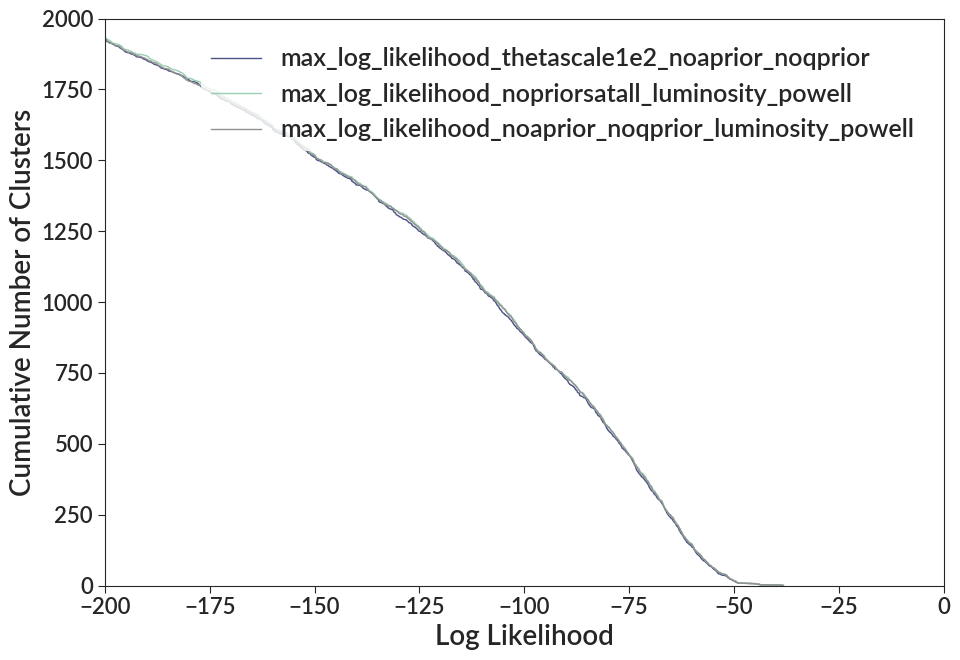

In [7]:
fig, ax = bpl.subplots()
bins = np.arange(-1000, 0, 10)

for col in big_cat.colnames:
    if "max_log_likelihood" in col:
        ax.plot(*make_cumulative_histogram(big_cat[col]), lw=1, label=col)

ax.set_limits(-200, 0, 0, 2000)
ax.legend()
ax.add_labels("Log Likelihood", "Cumulative Number of Clusters")

Essentially no change - any use of multiple starts seems to work

Then subtract off one of them from the others

In [11]:
relative_col = "max_log_likelihood_noaprior_noqprior_luminosity_powell"

In [15]:
rel_cols = []
for col in big_cat.colnames:
    if "max_log_likelihood" in col and "diff" not in col:
        big_cat[col + "_diff"] = big_cat[col] - big_cat[relative_col]
        rel_cols.append(col + "_diff")

Since we're subtracting off the reference, higher numbers mean higher likelihoods for the run in question.

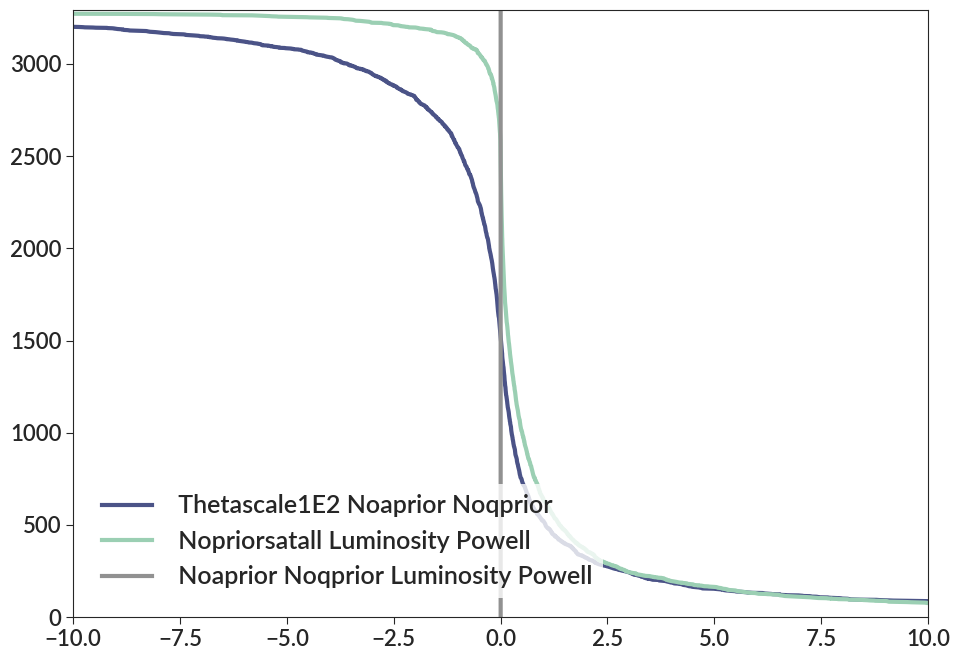

In [16]:
fig, ax = bpl.subplots()

bins = np.arange(-10, 10, 1)
for col in rel_cols:
    label = col.replace("max_log_likelihood", "")
    label = label.replace("_diff", "")
    label = label.replace("_", " ")
    label = label.title()
    ax.plot(*make_cumulative_histogram(big_cat[col]), label=label)
ax.legend()
ax.set_limits(-10, 10, 0, len(big_cat))